---

# Add prerequisites

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd

---

# Load `overloads` .csv

In [9]:
df1 = pd.read_csv('357164042518400_OLs.csv', delimiter=';', names=["Sensor_id", "Channel", "Device_id", "Latitude",
                                                                   "Longitude", "Speed", "Date", "Time", "Channel1", "Channel2"])
df1


Sensor_id  Channel        Device_id   Latitude  Longitude  Speed  \
0          60040  CANALE1  357164042518400  59.374611  17.997831    0.0   
1          60040  CANALE1  357164042518400  59.374611  17.997852    0.0   
2          60040  CANALE1  357164042518400  59.374611  17.997877    0.0   
3          60040  CANALE1  357164042518400  59.374610  17.997900    0.0   
4          60040  CANALE1  357164042518400  59.374609  17.997925    0.0   
...          ...      ...              ...        ...        ...    ...   
12600      61040  CANALE2  357164042518400  59.376685  17.991453    0.0   
12601      61040  CANALE2  357164042518400  59.376677  17.991481    0.0   
12602      61040  CANALE2  357164042518400  59.376670  17.991506    0.0   
12603      61040  CANALE2  357164042518400  59.376638  17.991621    0.0   
12604      60040  CANALE2  357164042518400  59.565632  16.238096    0.0   

           Date   Time  Channel1  Channel2  
0      20210304  41113     11200      4736  
1      20210304  41113    -11265       511  
2      20210304  41114     12464      2303  
3      20210304  41114    -11265       511  
4      20210304  41114     11644      1464  
...         ...    ...       ...       ...  
12600  20211108  23941     -2305    -11247  
12601  20211108  23941      -656     11472  
12602  20211108  23941      -560    -11272  
12603  20211108  23943      -832     11136  
12604  20211110  55759     -3376     13008  

[12605 rows x 10 columns]

---

# Pre-processing required (for overlods)

The acquired value is an integer number `[digit]` between 32768 and -32768. It can be converted
into a stress load using the sensitivity of 0.0068 `[MPa/digit]`. The absolute value is much more
important than the integer.

In [10]:
df1[['Channel1', 'Channel2']] = df1[['Channel1', 'Channel2']].apply(lambda x: abs(x * 0.0068), axis=1)
df1.head(15).style.background_gradient('coolwarm')


### Change `Date` and `Time` to DateTime

In [11]:
df1['Time'] = df1['Time'].apply(lambda x: str(
    datetime.strptime(str(x), "%H%M%S").time()))
df1['Date'] = df1['Date'].apply(lambda x: str(
    datetime.strptime(str(x), "%Y%m%d").date()))
df1.head(5).style.background_gradient('coolwarm')


### Add new col `max_overload`

We have some unused column that tell us wich channel is sampling? so we combine three channels with one channel that name is `max_overload`

In [12]:
df1['max_overload'] = np.max(df1[['Channel1', 'Channel2']].values, axis=1)
df1.head(5).style.background_gradient('coolwarm')


In [13]:
# x1 = df1
date_time = list(map(' '.join, df1[['Date', 'Time']].values.tolist()))
df1['Datetime'] = pd.to_datetime(pd.Series(date_time))
df1.head(5).style.background_gradient('coolwarm')

### Calculate distances

We want to see how much change in `latitude` and `longitude` is five meters?

In [14]:
from math import radians, cos, sin, asin, sqrt
def distance(lat1, lat2, lon1, lon2):
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = radians(lon1)
    lon2 = radians(lon2)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
 
    c = 2 * asin(sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)
     
     
# driver code
lat1 = 53.32055555555556
lat2 = 53.31861111111111
lon1 = -1.7297222222222221
lon2 =  -1.6997222222222223
print(distance(lat1, lat2, lon1, lon2), "K.M")

2.0043678382716137 K.M


In [15]:
a = np.sqrt(np.sum((np.array([lat1, lon1]) - np.array([lat2, lon2]))**2))
b = distance(lat1, lat2, lon1, lon2) * 1000

five_meter_degree = (5 * a) / b
print(five_meter_degree)

7.49935909658473e-05


---

# Load `Time seris` csv

In [16]:
    
df2 = pd.read_csv('357164042518400_THs.csv', delimiter=';', names=["Sensor_id", "Channel", "Device_id", "Latitude",
                                                                   "Longitude", "Speed", "Date", "Time"], skiprows=lambda x: x % 2 != 0)
df2['Time'] = df2['Time'].apply(lambda x: str(datetime.strptime(str(x), "%H%M%S").time()))
df2['Date'] = df2['Date'].apply(lambda x: str(datetime.strptime(str(x), "%Y%m%d").date()))
df2.head(15).style.background_gradient('coolwarm')


---

# Pre-processing required (for time series)

In [17]:
df3 = pd.read_csv('357164042518400_THs.csv', delimiter=';',
                  skiprows=lambda x: x % 2 == 0, names=list(range(5001)))
df4 = df3.abs().max(axis=1)
df2['max_overload'] = df4

In [18]:
df2[['max_overload']] = df2[['max_overload']].apply(
    lambda x: abs(x * 0.0068), axis=1)

date_time = list(map(' '.join, df2[['Date', 'Time']].values.tolist()))
df2['Datetime'] = pd.to_datetime(pd.Series(date_time))

df2.head(5).style.background_gradient('twilight_shifted_r')


## connect `time historys` to `overloads` **need to review**

#### Cluster near oveloads (<5m)

We cluster the coordinates in each `day`

In [19]:
from sklearn.cluster import MeanShift

In [33]:
# append df2 to df1

# assign label to time series data and overload data
df1['THs'] = 0
df2['THs'] = 1

df_total = df1.drop(['Channel1', 'Channel2'], axis=1).append(df2)
df_total.reset_index(drop='index', inplace=True)
df_total.head(5).style.background_gradient('Blues_r')

In [20]:
# unique_date = df_total.Datetime.unique().astype(str).tolist()

# clusters = []
# adder = 0
# for date in unique_date:
#     temp = df_total.loc[df_total['Datetime'] == date]
#     mean_shift = MeanShift(bandwidth=five_meter_degree)
#     coordinates = temp[['Latitude', 'Longitude']].values
#     mean_shift.fit(coordinates)
#     l = mean_shift.labels_
#     adder += (1 + max(l))
#     clusters += (mean_shift.labels_ + adder).tolist()
    

# df_total['5m_cluster'] = clusters
# df_total

# cluster df1 (overloads)
unique_date = df1.Datetime.unique().astype(str).tolist()

clusters = []
adder = 0
for date in unique_date:
    temp = df1.loc[df1['Datetime'] == date]
    mean_shift = MeanShift(bandwidth=five_meter_degree)
    coordinates = temp[['Latitude', 'Longitude']].values
    mean_shift.fit(coordinates)
    l = mean_shift.labels_
    adder += (1 + max(l))
    clusters += (mean_shift.labels_ + adder).tolist()
    

df1['5m_cluster'] = clusters
df1

Sensor_id  Channel        Device_id   Latitude  Longitude  Speed  \
0          60040  CANALE1  357164042518400  59.374611  17.997831    0.0   
1          60040  CANALE1  357164042518400  59.374611  17.997852    0.0   
2          60040  CANALE1  357164042518400  59.374611  17.997877    0.0   
3          60040  CANALE1  357164042518400  59.374610  17.997900    0.0   
4          60040  CANALE1  357164042518400  59.374609  17.997925    0.0   
...          ...      ...              ...        ...        ...    ...   
12600      61040  CANALE2  357164042518400  59.376685  17.991453    0.0   
12601      61040  CANALE2  357164042518400  59.376677  17.991481    0.0   
12602      61040  CANALE2  357164042518400  59.376670  17.991506    0.0   
12603      61040  CANALE2  357164042518400  59.376638  17.991621    0.0   
12604      60040  CANALE2  357164042518400  59.565632  16.238096    0.0   

             Date      Time  Channel1  Channel2  max_overload  \
0      2021-03-04  04:11:13   76.1600   32.2048       76.1600   
1      2021-03-04  04:11:13   76.6020    3.4748       76.6020   
2      2021-03-04  04:11:14   84.7552   15.6604       84.7552   
3      2021-03-04  04:11:14   76.6020    3.4748       76.6020   
4      2021-03-04  04:11:14   79.1792    9.9552       79.1792   
...           ...       ...       ...       ...           ...   
12600  2021-11-08  23:09:41   15.6740   76.4796       76.4796   
12601  2021-11-08  23:09:41    4.4608   78.0096       78.0096   
12602  2021-11-08  23:09:41    3.8080   76.6496       76.6496   
12603  2021-11-08  23:09:43    5.6576   75.7248       75.7248   
12604  2021-11-10  05:57:59   22.9568   88.4544       88.4544   

                 Datetime  5m_cluster  
0     2021-03-04 04:11:13           1  
1     2021-03-04 04:11:13           1  
2     2021-03-04 04:11:14           1  
3     2021-03-04 04:11:14           1  
4     2021-03-04 04:11:14           1  
...                   ...         ...  
12600 2021-11-08 23:09:41        1694  
12601 2021-11-08 23:09:41        1694  
12602 2021-11-08 23:09:41        1695  
12603 2021-11-08 23:09:43        1695  
12604 2021-11-10 05:57:59        1696  

[12605 rows x 13 columns]

In [21]:
# clustering time history series
unique_date = df2.Datetime.unique().astype(str).tolist()

clusters = []
adder = 0
for date in unique_date:
    temp = df2.loc[df2['Datetime'] == date]
    mean_shift = MeanShift(bandwidth=five_meter_degree)
    coordinates = temp[['Latitude', 'Longitude']].values
    mean_shift.fit(coordinates)
    l = mean_shift.labels_
    adder += (1 + max(l))
    clusters += (mean_shift.labels_ + adder).tolist()
    

df2['5m_cluster'] = clusters
df2

Sensor_id  Channel        Device_id   Latitude  Longitude  Speed  \
0        60040  CANALE1  357164042518400  59.372755  18.003537    0.0   
1        60040  CANALE1  357164042518400  59.373505  18.002518    0.0   
2        60040  CANALE1  357164042518400  59.373719  18.002101    0.0   
3        60040  CANALE1  357164042518400  59.374128  18.001012    0.0   
4        60040  CANALE1  357164042518400  59.372899  18.003275    0.0   
..         ...      ...              ...        ...        ...    ...   
388      60040  CANALE2  357164042518400  59.505874  15.988249    0.0   
389      60040  CANALE2  357164042518400  59.507716  15.990146    0.0   
390      60040  CANALE2  357164042518400  59.506697  15.988626    0.0   
391      60040  CANALE2  357164042518400  59.334602  18.050718    0.0   
392      60040  CANALE2  357164042518400  59.334303  18.051188    0.0   

           Date      Time  max_overload            Datetime  5m_cluster  
0    2021-03-04  04:12:15       90.0864 2021-03-04 04:12:15           1  
1    2021-03-04  04:12:00       93.0240 2021-03-04 04:12:00           1  
2    2021-03-04  04:11:54       90.4672 2021-03-04 04:11:54           2  
3    2021-03-04  04:11:43       91.0656 2021-03-04 04:11:43           2  
4    2021-03-04  04:12:12       97.4916 2021-03-04 04:12:12           3  
..          ...       ...           ...                 ...         ...  
388  2021-10-20  15:51:10       89.4336 2021-10-20 15:51:10         302  
389  2021-10-20  15:51:20       85.2448 2021-10-20 15:51:20         303  
390  2021-10-20  15:51:14       85.1904 2021-10-20 15:51:14         304  
391  2021-10-21  05:19:07       85.2924 2021-10-21 05:19:07         305  
392  2021-10-21  05:19:14       91.9564 2021-10-21 05:19:14         306  

[393 rows x 11 columns]

In [23]:
# chose most important data in our df that contains the max overload
important_nodes = []
for cluster in np.unique(df1['5m_cluster'].values):
    important_nodes.append(df1.loc[df1['5m_cluster']==cluster].sort_values('max_overload', ascending=False).iloc[0].values.tolist())
  
important_nodes_df = pd.DataFrame(important_nodes, columns=df1.columns)
imp_coord = important_nodes_df[['Latitude', 'Longitude']].values
important_nodes_df

Sensor_id  Channel        Device_id   Latitude  Longitude  Speed  \
0         60040  CANALE1  357164042518400  59.374611  17.997877    0.0   
1         60040  CANALE1  357164042518400  59.374604  17.998072    0.0   
2         60040  CANALE1  357164042518400  59.374128  18.001012    0.0   
3         60040  CANALE1  357164042518400  59.373728  18.002081    0.0   
4         60040  CANALE1  357164042518400  59.373567  18.002423    0.0   
...         ...      ...              ...        ...        ...    ...   
1532      61040  CANALE1  357164042518400  59.376835  17.989890    0.0   
1533      61040  CANALE1  357164042518400  59.376674  17.991494    0.0   
1534      61040  CANALE2  357164042518400  59.376677  17.991481    0.0   
1535      61040  CANALE2  357164042518400  59.376670  17.991506    0.0   
1536      60040  CANALE2  357164042518400  59.565632  16.238096    0.0   

            Date      Time  Channel1  Channel2  max_overload  \
0     2021-03-04  04:11:14   84.7552   15.6604       84.7552   
1     2021-03-04  04:11:15   88.5632   11.3152       88.5632   
2     2021-03-04  04:11:43   91.0656    2.4480       91.0656   
3     2021-03-04  04:11:54   85.7344   15.2320       85.7344   
4     2021-03-04  04:11:58   91.8272    7.3984       91.8272   
...          ...       ...       ...       ...           ...   
1532  2021-11-08  23:09:26   86.3872   10.0096       86.3872   
1533  2021-11-08  23:09:41   80.1856    2.2848       80.1856   
1534  2021-11-08  23:09:41    4.4608   78.0096       78.0096   
1535  2021-11-08  23:09:41    3.8080   76.6496       76.6496   
1536  2021-11-10  05:57:59   22.9568   88.4544       88.4544   

                Datetime  5m_cluster  
0    2021-03-04 04:11:14           1  
1    2021-03-04 04:11:15           2  
2    2021-03-04 04:11:43           3  
3    2021-03-04 04:11:54           4  
4    2021-03-04 04:11:58           5  
...                  ...         ...  
1532 2021-11-08 23:09:26        1692  
1533 2021-11-08 23:09:41        1693  
1534 2021-11-08 23:09:41        1694  
1535 2021-11-08 23:09:41        1695  
1536 2021-11-10 05:57:59        1696  

[1537 rows x 13 columns]

In [22]:
important_nodes = []
for cluster in np.unique(df2['5m_cluster'].values):
    important_nodes.append(df2.loc[df2['5m_cluster']==cluster].sort_values('max_overload', ascending=False).iloc[0].values.tolist())
  
important_nodes_df_2 = pd.DataFrame(important_nodes, columns=df2.columns)
imp_coord = important_nodes_df_2[['Latitude', 'Longitude']].values
important_nodes_df_2


Sensor_id  Channel        Device_id   Latitude  Longitude  Speed  \
0        60040  CANALE1  357164042518400  59.373505  18.002518    0.0   
1        60040  CANALE1  357164042518400  59.374128  18.001012    0.0   
2        60040  CANALE1  357164042518400  59.372899  18.003275    0.0   
3        60040  CANALE1  357164042518400  59.365934  18.008505    0.0   
4        60040  CANALE1  357164042518400  57.752946  12.218611    0.0   
..         ...      ...              ...        ...        ...    ...   
292      60040  CANALE2  357164042518400  59.505874  15.988249    0.0   
293      60040  CANALE2  357164042518400  59.507716  15.990146    0.0   
294      60040  CANALE2  357164042518400  59.506697  15.988626    0.0   
295      60040  CANALE2  357164042518400  59.334602  18.050718    0.0   
296      60040  CANALE2  357164042518400  59.334303  18.051188    0.0   

           Date      Time  max_overload            Datetime  5m_cluster  
0    2021-03-04  04:12:00       93.0240 2021-03-04 04:12:00           1  
1    2021-03-04  04:11:43       91.0656 2021-03-04 04:11:43           2  
2    2021-03-04  04:12:12       97.4916 2021-03-04 04:12:12           3  
3    2021-03-04  04:15:16       92.2556 2021-03-04 04:15:16           4  
4    2021-04-03  06:10:01       95.7372 2021-04-03 06:10:01           5  
..          ...       ...           ...                 ...         ...  
292  2021-10-20  15:51:10       89.4336 2021-10-20 15:51:10         302  
293  2021-10-20  15:51:20       85.2448 2021-10-20 15:51:20         303  
294  2021-10-20  15:51:14       85.1904 2021-10-20 15:51:14         304  
295  2021-10-21  05:19:07       85.2924 2021-10-21 05:19:07         305  
296  2021-10-21  05:19:14       91.9564 2021-10-21 05:19:14         306  

[297 rows x 11 columns]

In [24]:
date_time1 = important_nodes_df['Date'].values.tolist()
date_time2 = important_nodes_df_2['Date'].values.tolist()
max1 = important_nodes_df['max_overload'].values.tolist()
max2 = important_nodes_df_2['max_overload'].values.tolist()
cluster_1 = important_nodes_df['5m_cluster'].values.tolist()
cluster_2 = important_nodes_df_2['5m_cluster'].values.tolist()

counter = 0
similar = []
df1['THs_clusters'] = -1
important_nodes_df['THs_clusters'] = -1
for d1, m1, c1 in zip(date_time1, max1, cluster_1):
    for d2, m2, c2 in zip(date_time2, max1, cluster_2):
        if d1 == d2 and m1 == m2:
            df1.loc[df1['5m_cluster'] == c1, 'THs_clusters'] = c2
            important_nodes_df.loc[important_nodes_df['5m_cluster'] == c1, 'THs_clusters'] = c2
            similar.append((c1, c2))
            counter += 1

print(counter)            
print(similar)
df1

49
[(1, 1), (2, 2), (3, 3), (4, 4), (46, 4), (47, 146), (66, 152), (95, 151), (165, 153), (166, 154), (167, 155), (168, 156), (169, 157), (299, 171), (306, 165), (329, 22), (352, 171), (364, 18), (719, 56), (735, 52), (862, 69), (902, 60), (916, 60), (969, 207), (1027, 212), (1030, 218), (1043, 218), (1094, 236), (1095, 95), (1100, 90), (1121, 225), (1131, 95), (1169, 244), (1179, 245), (1189, 252), (1202, 252), (1225, 268), (1237, 268), (1249, 119), (1283, 254), (1301, 257), (1323, 128), (1328, 130), (1328, 275), (1382, 278), (1488, 293), (1492, 295), (1518, 136), (1620, 301)]


Sensor_id  Channel        Device_id   Latitude  Longitude  Speed  \
0          60040  CANALE1  357164042518400  59.374611  17.997831    0.0   
1          60040  CANALE1  357164042518400  59.374611  17.997852    0.0   
2          60040  CANALE1  357164042518400  59.374611  17.997877    0.0   
3          60040  CANALE1  357164042518400  59.374610  17.997900    0.0   
4          60040  CANALE1  357164042518400  59.374609  17.997925    0.0   
...          ...      ...              ...        ...        ...    ...   
12600      61040  CANALE2  357164042518400  59.376685  17.991453    0.0   
12601      61040  CANALE2  357164042518400  59.376677  17.991481    0.0   
12602      61040  CANALE2  357164042518400  59.376670  17.991506    0.0   
12603      61040  CANALE2  357164042518400  59.376638  17.991621    0.0   
12604      60040  CANALE2  357164042518400  59.565632  16.238096    0.0   

             Date      Time  Channel1  Channel2  max_overload  \
0      2021-03-04  04:11:13   76.1600   32.2048       76.1600   
1      2021-03-04  04:11:13   76.6020    3.4748       76.6020   
2      2021-03-04  04:11:14   84.7552   15.6604       84.7552   
3      2021-03-04  04:11:14   76.6020    3.4748       76.6020   
4      2021-03-04  04:11:14   79.1792    9.9552       79.1792   
...           ...       ...       ...       ...           ...   
12600  2021-11-08  23:09:41   15.6740   76.4796       76.4796   
12601  2021-11-08  23:09:41    4.4608   78.0096       78.0096   
12602  2021-11-08  23:09:41    3.8080   76.6496       76.6496   
12603  2021-11-08  23:09:43    5.6576   75.7248       75.7248   
12604  2021-11-10  05:57:59   22.9568   88.4544       88.4544   

                 Datetime  5m_cluster  THs_clusters  
0     2021-03-04 04:11:13           1             1  
1     2021-03-04 04:11:13           1             1  
2     2021-03-04 04:11:14           1             1  
3     2021-03-04 04:11:14           1             1  
4     2021-03-04 04:11:14           1             1  
...                   ...         ...           ...  
12600 2021-11-08 23:09:41        1694            -1  
12601 2021-11-08 23:09:41        1694            -1  
12602 2021-11-08 23:09:41        1695            -1  
12603 2021-11-08 23:09:43        1695            -1  
12604 2021-11-10 05:57:59        1696            -1  

[12605 rows x 14 columns]

### the variation of the overloads according to speed

Sensor_id  Device_id  Latitude  Longitude     Speed  Channel1  \
Sensor_id      1.000000        NaN  0.064102   0.026184 -0.044467 -0.153989   
Device_id           NaN        NaN       NaN        NaN       NaN       NaN   
Latitude       0.064102        NaN  1.000000   0.772362 -0.377825 -0.029900   
Longitude      0.026184        NaN  0.772362   1.000000 -0.368364 -0.034926   
Speed         -0.044467        NaN -0.377825  -0.368364  1.000000 -0.034210   
Channel1      -0.153989        NaN -0.029900  -0.034926 -0.034210  1.000000   
Channel2       0.139029        NaN  0.088081   0.059092 -0.013913 -0.949646   
max_overload   0.006752        NaN  0.279910   0.289622 -0.298806  0.194471   
5m_cluster     0.107147        NaN  0.634917   0.466720 -0.350323 -0.083564   
THs_clusters   0.026380        NaN -0.108550  -0.095613 -0.009667 -0.066197   

              Channel2  max_overload  5m_cluster  THs_clusters  
Sensor_id     0.139029      0.006752    0.107147      0.026380  
Device_id          NaN           NaN         NaN           NaN  
Latitude      0.088081      0.279910    0.634917     -0.108550  
Longitude     0.059092      0.289622    0.466720     -0.095613  
Speed        -0.013913     -0.298806   -0.350323     -0.009667  
Channel1     -0.949646      0.194471   -0.083564     -0.066197  
Channel2      1.000000      0.034510    0.104246      0.094220  
max_overload  0.034510      1.000000    0.122986      0.066972  
5m_cluster    0.104246      0.122986    1.000000     -0.019119  
THs_clusters  0.094220      0.066972   -0.019119      1.000000

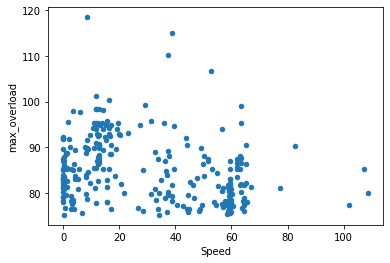

In [51]:
important_nodes_df.where(0 < important_nodes_df['Speed']).plot.scatter('Speed', 'max_overload')
important_nodes_df.where(0 < important_nodes_df['Speed']).corr()

### the trend of the velocity

In [25]:
df1_imp_copy = important_nodes_df.copy()
df1_imp_copy = df1_imp_copy.sort_values('Datetime')

total_velocity = []
for date in np.unique(df1_imp_copy['Date'].values).tolist():  # select the unique values of the dates and convert it to list
    temp_df = df1_imp_copy.loc[df1_imp_copy['Date'] == date]
    coords = temp_df[['Latitude', 'Longitude']].values
    x1 = coords[:-1]
    x2 = coords[1:]
    if not x1.tolist():
        velocity = [0]
        total_velocity += velocity
        continue

    delta_x = np.linalg.norm(x2 - x1, axis=1)
    delta_x_meter = delta_x / (five_meter_degree / 5)

    time1 = temp_df['Datetime'].iloc[:-1].apply(lambda x: x.timestamp()).values # we covert to timestamp this because of zero time conversion.
    time2 = temp_df['Datetime'].iloc[1:].apply(lambda x: x.timestamp()).values  # we covert to timestamp this because of zero time conversion.
    delta_t = (time2 - time1) + 0.1
    velocity = delta_x_meter / delta_t
    velocity *= 3.6
    velocity = [0] + velocity.tolist() # add zero for the end of line
    total_velocity += velocity

df1_imp_copy['velocity'] = total_velocity
df1_imp_copy

    

Sensor_id  Channel        Device_id   Latitude  Longitude  Speed  \
7         60040  CANALE2  357164042518400  59.374611  17.997841    0.0   
0         60040  CANALE1  357164042518400  59.374611  17.997877    0.0   
8         60040  CANALE2  357164042518400  59.374610  17.997888    0.0   
1         60040  CANALE1  357164042518400  59.374604  17.998072    0.0   
9         60040  CANALE2  357164042518400  59.374603  17.998083    0.0   
...         ...      ...              ...        ...        ...    ...   
1534      61040  CANALE2  357164042518400  59.376677  17.991481    0.0   
1535      61040  CANALE2  357164042518400  59.376670  17.991506    0.0   
1531      60040  CANALE2  357164042518400  59.376686  17.991448    0.0   
1533      61040  CANALE1  357164042518400  59.376674  17.991494    0.0   
1536      60040  CANALE2  357164042518400  59.565632  16.238096    0.0   

            Date      Time  Channel1  Channel2  max_overload  \
7     2021-03-04  04:11:13    8.0512   82.9056       82.9056   
0     2021-03-04  04:11:14   84.7552   15.6604       84.7552   
8     2021-03-04  04:11:14    1.9584   81.0560       81.0560   
1     2021-03-04  04:11:15   88.5632   11.3152       88.5632   
9     2021-03-04  04:11:15   11.9680   89.7600       89.7600   
...          ...       ...       ...       ...           ...   
1534  2021-11-08  23:09:41    4.4608   78.0096       78.0096   
1535  2021-11-08  23:09:41    3.8080   76.6496       76.6496   
1531  2021-11-08  23:09:41    3.1552   79.0976       79.0976   
1533  2021-11-08  23:09:41   80.1856    2.2848       80.1856   
1536  2021-11-10  05:57:59   22.9568   88.4544       88.4544   

                Datetime  5m_cluster  THs_clusters    velocity  
7    2021-03-04 04:11:13           8            -1    0.000000  
0    2021-03-04 04:11:14           1             1    7.838432  
8    2021-03-04 04:11:14           9            -1   26.964748  
1    2021-03-04 04:11:15           2             2   40.143304  
9    2021-03-04 04:11:15          10            -1   26.371926  
...                  ...         ...           ...         ...  
1534 2021-11-08 23:09:41        1694            -1   22.601304  
1535 2021-11-08 23:09:41        1695            -1   62.879696  
1531 2021-11-08 23:09:41        1691            -1  143.228579  
1533 2021-11-08 23:09:41        1693            -1  112.602822  
1536 2021-11-10 05:57:59        1696            -1    0.000000  

[1537 rows x 15 columns]

In [26]:
important_nodes_df['velocity'] = total_velocity

In [27]:
# Calculate velocity on complete data
df1_copy = df1.copy()
datetime = list(map(' '.join, df1_copy[['Date', 'Time']].values.tolist()))
df1_copy['Datetime'] = pd.to_datetime(pd.Series(datetime))

df1_copy = df1_copy.sort_values('Datetime')

total_velocity = []
for date in np.unique(df1_copy['Date'].values).tolist():  # select the unique values of the dates and convert it to list
    temp_df = df1_copy.loc[df1_copy['Date'] == date]
    coords = temp_df[['Latitude', 'Longitude']].values
    x1 = coords[:-1]
    x2 = coords[1:]
    if not x1.tolist():
        velocity = [0]
        total_velocity += velocity
        continue

    delta_x = np.linalg.norm(x2 - x1, axis=1)
    delta_x_meter = delta_x / (five_meter_degree / 5)

    time1 = temp_df['Datetime'].iloc[:-1].apply(lambda x: x.timestamp()).values # we covert to timestamp this because of zero time conversion.
    time2 = temp_df['Datetime'].iloc[1:].apply(lambda x: x.timestamp()).values  # we covert to timestamp this because of zero time conversion.
    delta_t = (time2 - time1) + 0.1
    velocity = delta_x_meter / delta_t
    velocity *= 3.6
    velocity = [0] + velocity.tolist() # add zero for the end of line
    total_velocity += velocity

df1['velocity'] = total_velocity
df1.head(15).style.background_gradient('coolwarm')


### it is assumed that the higher velocity, the higher overload

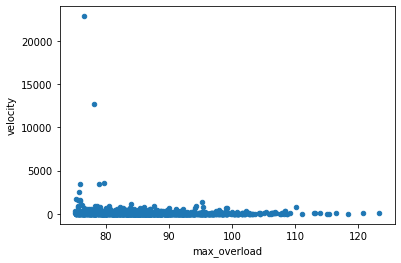

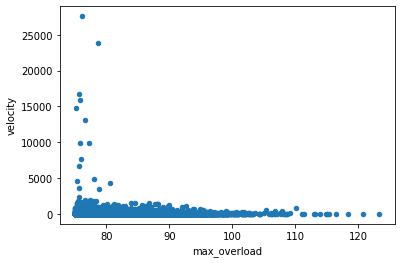

In [28]:
important_nodes_df.plot.scatter('max_overload', 'velocity')
plt.show()

df1.plot.scatter('max_overload', 'velocity')
plt.show()

# Activites

## Summary statistics

In [71]:
important_df = df1[['Channel', 'Time', 'Channel1', 'Channel2', 'max_overload', 'Speed', 'velocity']]
important_df.describe()

Channel1      Channel2  max_overload         Speed      velocity
count  12605.00000  12605.000000  12605.000000  12605.000000  12605.000000
mean      49.74467     42.385125     82.896242      3.211854    109.492095
std       37.23737     37.422452      5.521888     11.367294    480.397695
min        0.00000      0.000000     75.010800      0.000000      0.000000
25%        7.88800      6.201600     78.553600      0.000000     16.554437
50%       76.37760     20.617600     82.252800      0.000000     47.078266
75%       82.90560     81.328000     85.897600      0.000000    109.891466
max      118.48320    123.379200    123.379200    108.599221  27576.740267

#### Are there any values that don’t make sense? If so, what should you do about them?
Yes , We have some velocity that doesn't make sense because the max value is too high or our speed data is zero most of the time. we can remove this outliers 
in our calculations. For example we choose velocity between 25% quantile and third 75% quantile.  


#### Are there any missing values? How will you deal with them?
In our data, they don't define any missing value. So if we have some missing values we drop them from our dataframe and estimate them by our trained model.

## Feature distributions

Our important columns: `max_overload`, 

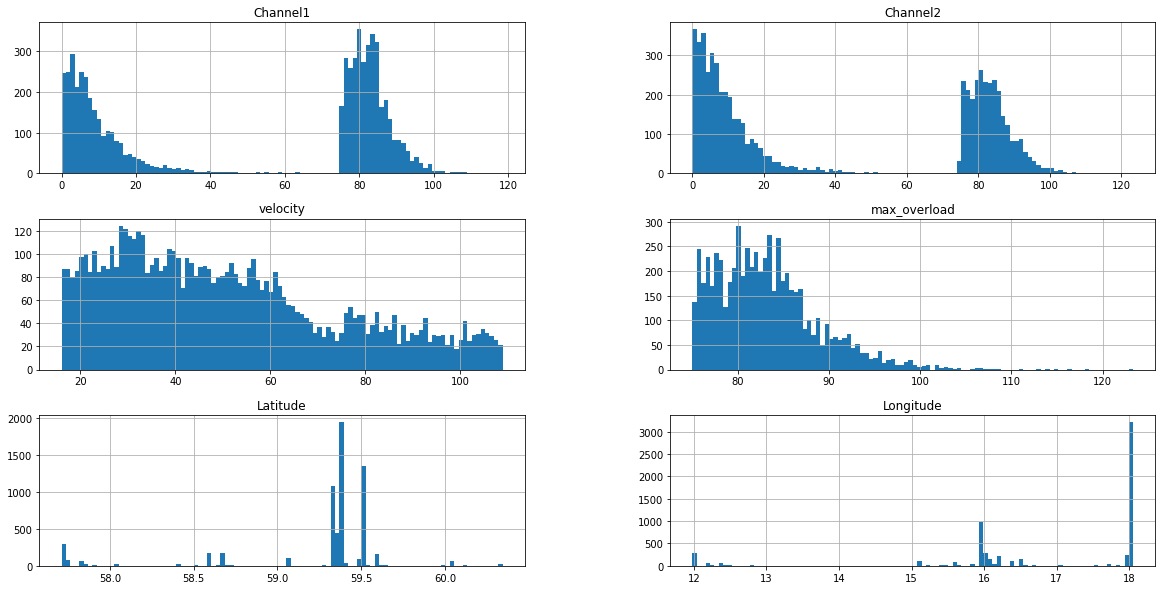

In [74]:
df1.where((16 < df1['velocity'])& (df1['velocity'] < 109), None).hist(['Channel1', 'Channel2', 'velocity', 'max_overload', 'Latitude', 'Longitude'], figsize=(20, 10), bins=100)  # Choose the 25% - 75% velocity 
plt.show()

#### Do the distributions make sense?

No doesn't make sense!

#### Are there any outliers in the data? How will you remove them?

we can remove the outliers by std of our distributions our selecting by the quntile.

## Feature correlations

#### Plot a heatmap of correlations between features.

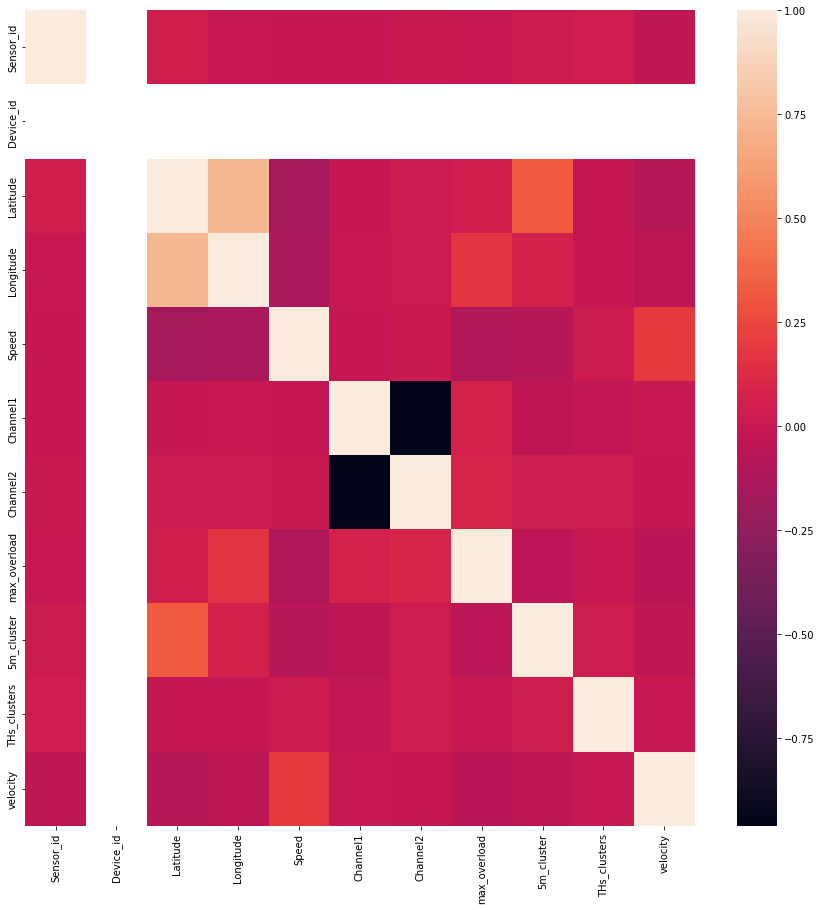

In [77]:
import seaborn as sn
plt.figure(figsize=(15, 15))
sn.heatmap(df1.corr())
plt.show()

#### Are any of the columns highly correlated with one another? Can you explain the correlation?

No

####  E.g., is there Is there a relationship between the speed and the overload? If so, what is it?

In our calculations, there is no correlation between `max_overload` and calculated `velocity`



#### You may want to generate scatter plots to see what the relationship is between numeric variables.

count    12605.000000
mean       109.492095
std        480.397695
min          0.000000
25%         16.554437
50%         47.078266
75%        109.891466
max      27576.740267
Name: velocity, dtype: float64


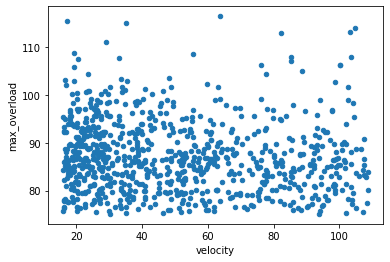

count    12605.000000
mean       109.492095
std        480.397695
min          0.000000
25%         16.554437
50%         47.078266
75%        109.891466
max      27576.740267
Name: velocity, dtype: float64


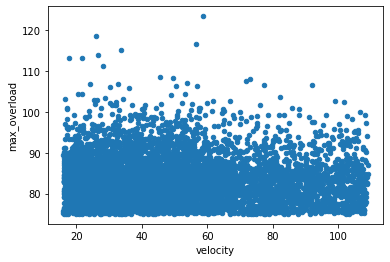

In [78]:
print(df1['velocity'].describe())
important_nodes_df.where((16 < important_nodes_df['velocity'])& (important_nodes_df['velocity'] < 109), None).plot.scatter('velocity', 'max_overload')
plt.show()

print(df1['velocity'].describe())
df1.where((16 < df1['velocity'])& (df1['velocity'] < 109), None).plot.scatter('velocity', 'max_overload')
plt.show()

## Time series aspects

## Are there more overloads in winter or summer

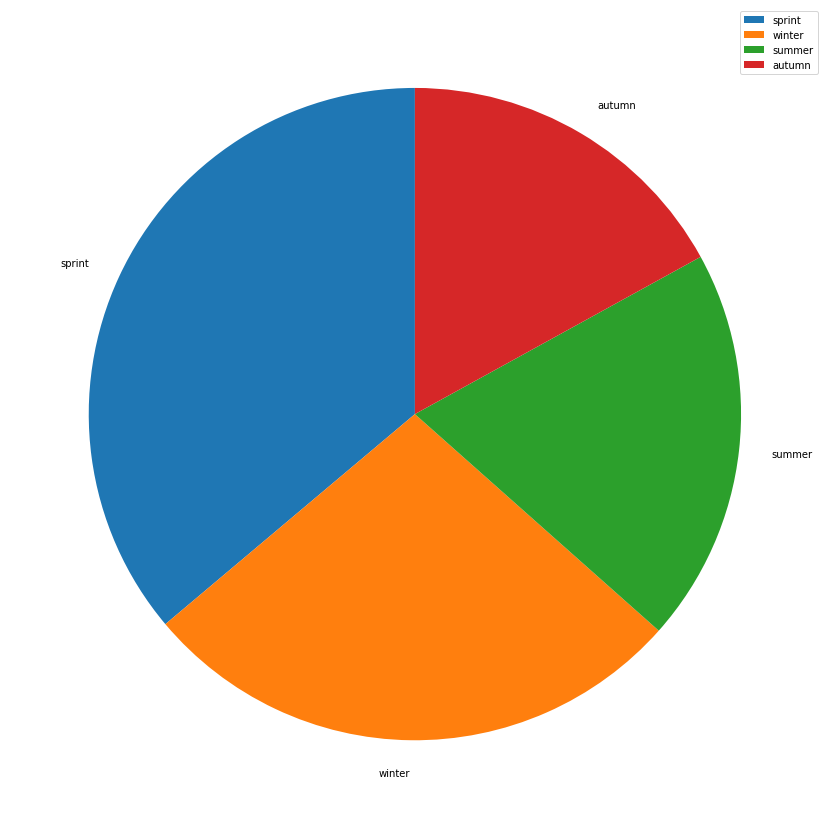

In [79]:
# we add new feature and that is season ...
df1['season'] = df1['Datetime'].dt.month


def season_extractor(month):
    if 2 < month <= 5:
        return 'sprint'
    elif 6 < month <= 8:
        return 'summer'
    elif 8 < month <= 10:
        return 'autumn'
    else:
        return 'winter'


df1['season'] = df1['season'].apply(season_extractor)


plt.figure(figsize=(15, 15))

plt.pie(df1['season'].value_counts(), labels=df1['season'].unique() ,startangle=90)
plt.legend()
plt.show()


**Answer:** No this not true ...

### Which day of the week is more? Why?

In [80]:
#add day of weak to our dataframe:

df1['day_of_weak'] = df1['Datetime'].dt.weekday
df1['day_of_weak'].value_counts()

4    3374
1    2621
2    2112
3    1571
5    1563
0     894
6     470
Name: day_of_weak, dtype: int64

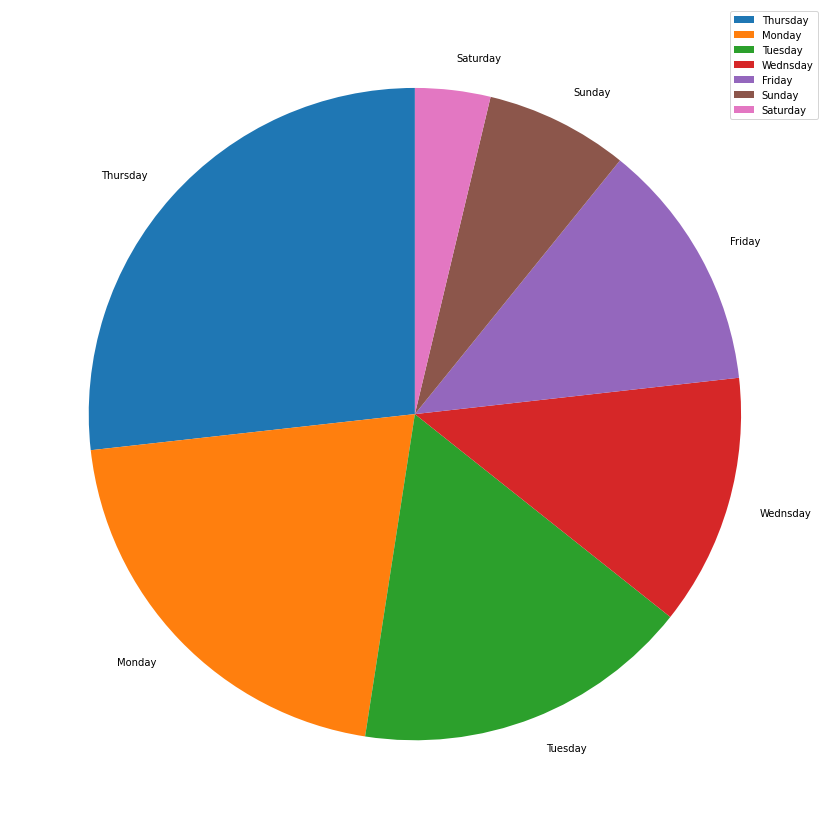

In [81]:
plt.figure(figsize=(15, 15))

plt.pie(df1['day_of_weak'].value_counts(),
        labels=['Thursday', 'Monday', 'Tuesday', 'Wednsday', 'Friday', 'Sunday', 'Saturday'], startangle=90)
plt.legend()
plt.show()



**Answer:** Tuesday

### What time of day?

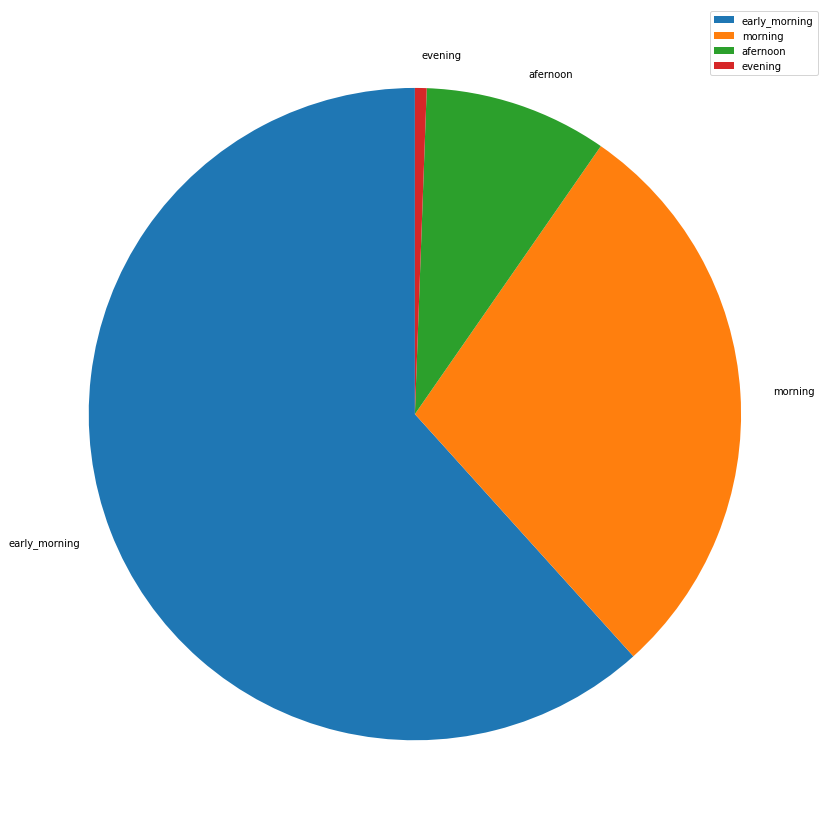

In [82]:
def timeـclassification(val):
    val = int(val.split(':')[0])
    if val < 6:
        return 'early_morning'
    elif 6 <= val <= 12:
        return 'morning'
    elif 12 < val < 18:
        return 'afernoon'
    else:
        return 'evening'


df1['time_of_day'] = df1['Time'].apply(timeـclassification)
plt.figure(figsize=(15, 15))

plt.pie(df1['time_of_day'].value_counts(),
        labels=df1['time_of_day'].unique(), startangle=90)
plt.legend()
plt.show()



**Answer:** Early morning

## Spatial characteristics:

### Visualise the overloads data on a map.

In [83]:
import geopandas as gpd
import matplotlib
import folium
# important_nodes_df['random'] = [list(range(1000)) for _ in range(len(important_nodes_df))]

gdf = gpd.GeoDataFrame(important_nodes_df.drop(['Datetime'], axis=1), geometry=gpd.points_from_xy(
    important_nodes_df.Longitude, important_nodes_df.Latitude))

gdf_2 = gpd.GeoDataFrame(important_nodes_df_2.drop(['Datetime'], axis=1), geometry=gpd.points_from_xy(
    important_nodes_df_2.Longitude, important_nodes_df_2.Latitude))

# sweden_map = gpd.read_file('gis_map/test.shp')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# ax = sweden_map.plot(figsize=(15, 15))
# gdf.plot(ax=ax, color='red')
m = world.explore()
m =gdf_2.explore(m=m, color='green', marker_kwds={"radius": 10}, popup=['max_overload'])
gdf.explore(m=m, marker_type="circle_marker", color='red', marker_kwds={"radius": 5}, popup=['max_overload'])


### <i><s>Can you see any particular spatial features of the accidents?</i></s>

Don't get the meaning.

## Contributing factors and overloads

#### How does the speed and others affect the overloads?
We don't see any correlation in correlation map.

## Build predictive models:

#### Build and evaluate both regression and classification models on the data.
#### Can you predict the severity of the overloads based on the velocity and locations?

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

x_df = df1.drop(['Sensor_id', 'Channel', 'Device_id', 'Speed', 'Date','Time', 'Datetime', '5m_cluster', 'THs_clusters', 'Channel1', 'Channel2'], axis=1)
x_df = pd.get_dummies(x_df, columns=['day_of_weak', 'season', 'time_of_day'])
x_df['velocity'] = x_df['velocity'].clip(lower=0, upper=110)



In [137]:
x = x_df[['velocity', 'Latitude', 'Longitude']].values
y = x_df['max_overload'].values

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, shuffle=True, random_state=1234)

svm = SVR(verbose=True)
svm.fit(x_train, y_train)

pred_test = svm.score(x_test, y_test)
print(pred_test)


[LibSVM].....
*
optimization finished, #iter = 5617
obj = -34069.469750, rho = -86.145295
nSV = 8670, nBSV = 8646
0.1262551332430546


#### Does the prediction performance change if you include time feature

In [144]:
x = x_df.drop('max_overload', axis=1).values
y = x_df['max_overload'].values

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
# y_scaled = scaler.fit_transform(y)
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.3, shuffle=True, random_state=1234)

svm = SVR(verbose=True)
svm.fit(x_train, y_train)

pred_test = svm.score(x_test, y_test)
print(pred_test)

[LibSVM].....
*
optimization finished, #iter = 5537
obj = -27705.204279, rho = -81.406332
nSV = 8616, nBSV = 8549
0.3582805492147487


#### Does the prediction performance change if you include time feature?

Yes, We gain the score 0.35 than it 3 times better than the previous score.

#### What other features are important?
None